In [1]:
import numpy as np
from math import sqrt

In [2]:
class FreshReplay:
    def add(self, x):
        self.exp = x
    def sample(self, b, m_e):
        return [self.exp], self.exp, [1 for _ in range(b)]

In [3]:
class UniformReplay:
    def __init__(self):
        self.exps = []
        self.exps_at_t = []
    def add(self, x):
        self.exps.append(x)
    def sample(self, b, m_e):
        indices = np.random.randint(low=0, high=len(self.exps), size=b)
        expectation = sum(self.exps) / len(self.exps)
        self.exps_at_t.append([self.exps[i] for i in indices])
        return [self.exps[i] for i in indices], expectation, [1 for _ in range(b)]

In [95]:
class PrioritisedReplay:
    def __init__(self, alpha=0.7):
        self.exps = []
        self.exps_at_t = []
        self.distrib_at_t = []
        self.alpha = 0.7
    def add(self, x):
        self.exps.append((10,x)) # (Error, value)
    def sample(self, b, model_estimate):
        self.exps.sort(reverse=True)
        sampling_distrib = np.array([pow(1/(i+1), self.alpha) for i in range(len(self.exps))])
        sampling_distrib /= np.sum(sampling_distrib)
        indices = np.random.choice([i for i in range(len(self.exps))], p=sampling_distrib, size=b)
        sampled = [self.exps[i][1] for i in indices]
        # Update td error
        for i in indices:
            td_error = abs(self.exps[i][1] - model_estimate)
#             td_error = min(td_error, 0.001)
            current_exp = self.exps[i]
            self.exps[i] = (td_error, current_exp[1])
        # Expectation
        expectation = 0
        for p, d in zip(sampling_distrib, self.exps):
            expectation += float(p) * d[1]
        is_weights = [(1/(len(self.exps) * sampling_distrib[i])) for i in indices]
        max_wi = 1/(len(self.exps) * sampling_distrib[-1])
        normalised_is_weights = [w/max_wi for w in is_weights]
        
#         normalised_is_weights = [1 for _ in normalised_is_weights]
        
        self.exps_at_t.append(sampled)
        self.distrib_at_t.append([(pa, wa[1]) for pa, wa in zip(sampling_distrib, self.exps)])
        
        return sampled, expectation, normalised_is_weights

In [96]:
class Model:
    def __init__(self, lr):
        self.lr = lr
        self.estimate = 0
    def output(self):
        return self.estimate
    def train(self, xs, weights):
        batch_error = 0
        for x, w in zip(xs, weights):
            batch_error += w * (self.estimate - x)
        self.estimate -= self.lr * (batch_error / len(xs))

In [97]:
dataset = [1/sqrt(n + 1) for n in range(0,100,5)]
timesteps = 100
t_max_extra = (10) * timesteps

In [98]:
def get_estimates(replay, model_lr=0.01, batch_size=1):

    model = Model(model_lr)

    model_estimates = []
    replay_expecatations = []
    model_estimate = model.output()
    model_estimates.append(model_estimate)
    for d in dataset:
        replay.add(d)
        for _ in range(timesteps):
            xs, e, ws = replay.sample(batch_size, model_estimate)
            model.train(xs, ws)
            model_estimate = model.output()
            model_estimates.append(model_estimate)
            replay_expecatations.append(e)
            
    for _ in range(t_max_extra):
        xs, e, ws = replay.sample(batch_size, model_estimate)
        model.train(xs, ws)
        model_estimate = model.output()
        model_estimates.append(model_estimate)
        replay_expecatations.append(e)

    return model_estimates, replay_expecatations

In [99]:
model_lr = 0.1

In [100]:
batch_size = 1

In [101]:
fresh_estimates, fresh_exps = get_estimates(FreshReplay(), model_lr, batch_size)
uniform_replay = UniformReplay()
uniform_estimates, uniform_exps = get_estimates(uniform_replay, model_lr, batch_size)
p_replay = PrioritisedReplay(alpha=0.7)
p_estimates, p_exps = get_estimates(p_replay, model_lr, batch_size)

In [102]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

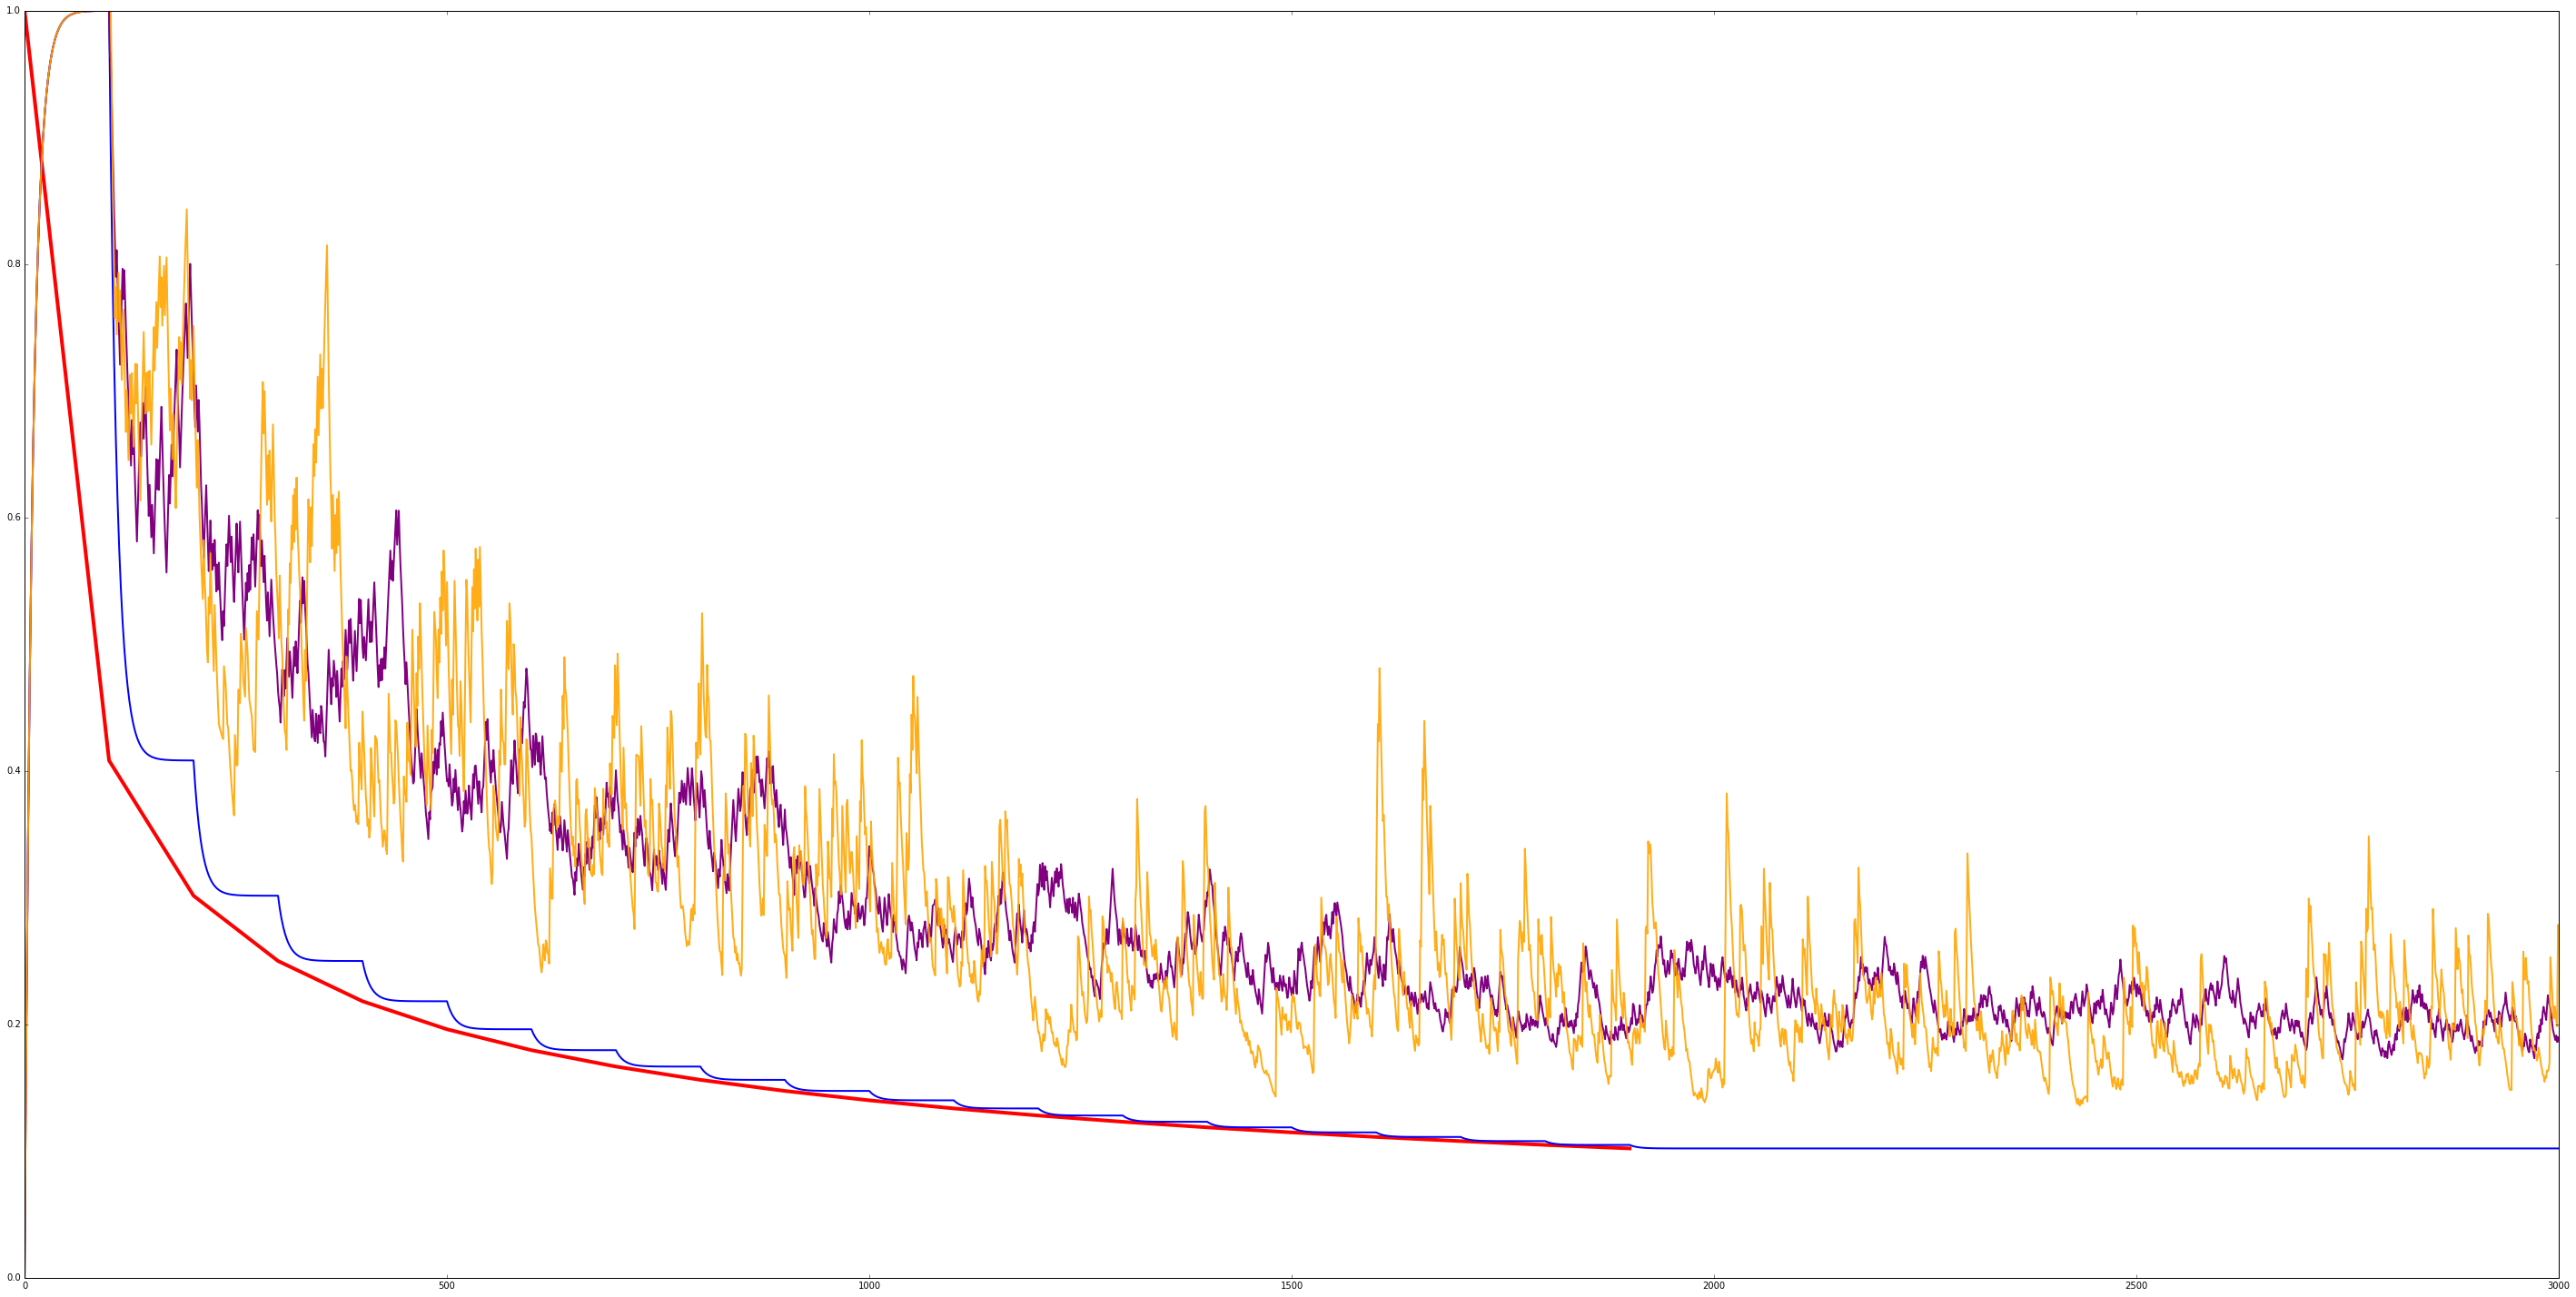

In [103]:
plt.figure(figsize=(50,25))
# Ground truth
plt.plot([i*timesteps for i in range(len(dataset))], dataset, color="r", linewidth=4)

plt.plot([i for i in range(len(fresh_estimates))], fresh_estimates, color="b", linewidth=2)

# plt.plot([i for i in range(len(uniform_estimates))], uniform_estimates, color="g", linewidth=2)

plt.plot([i for i in range(len(p_estimates))], p_estimates, color="purple", linewidth=2)

plt.plot([i for i in range(len(uniform_estimates))], uniform_estimates, color="orange", alpha=0.9,linewidth=2)

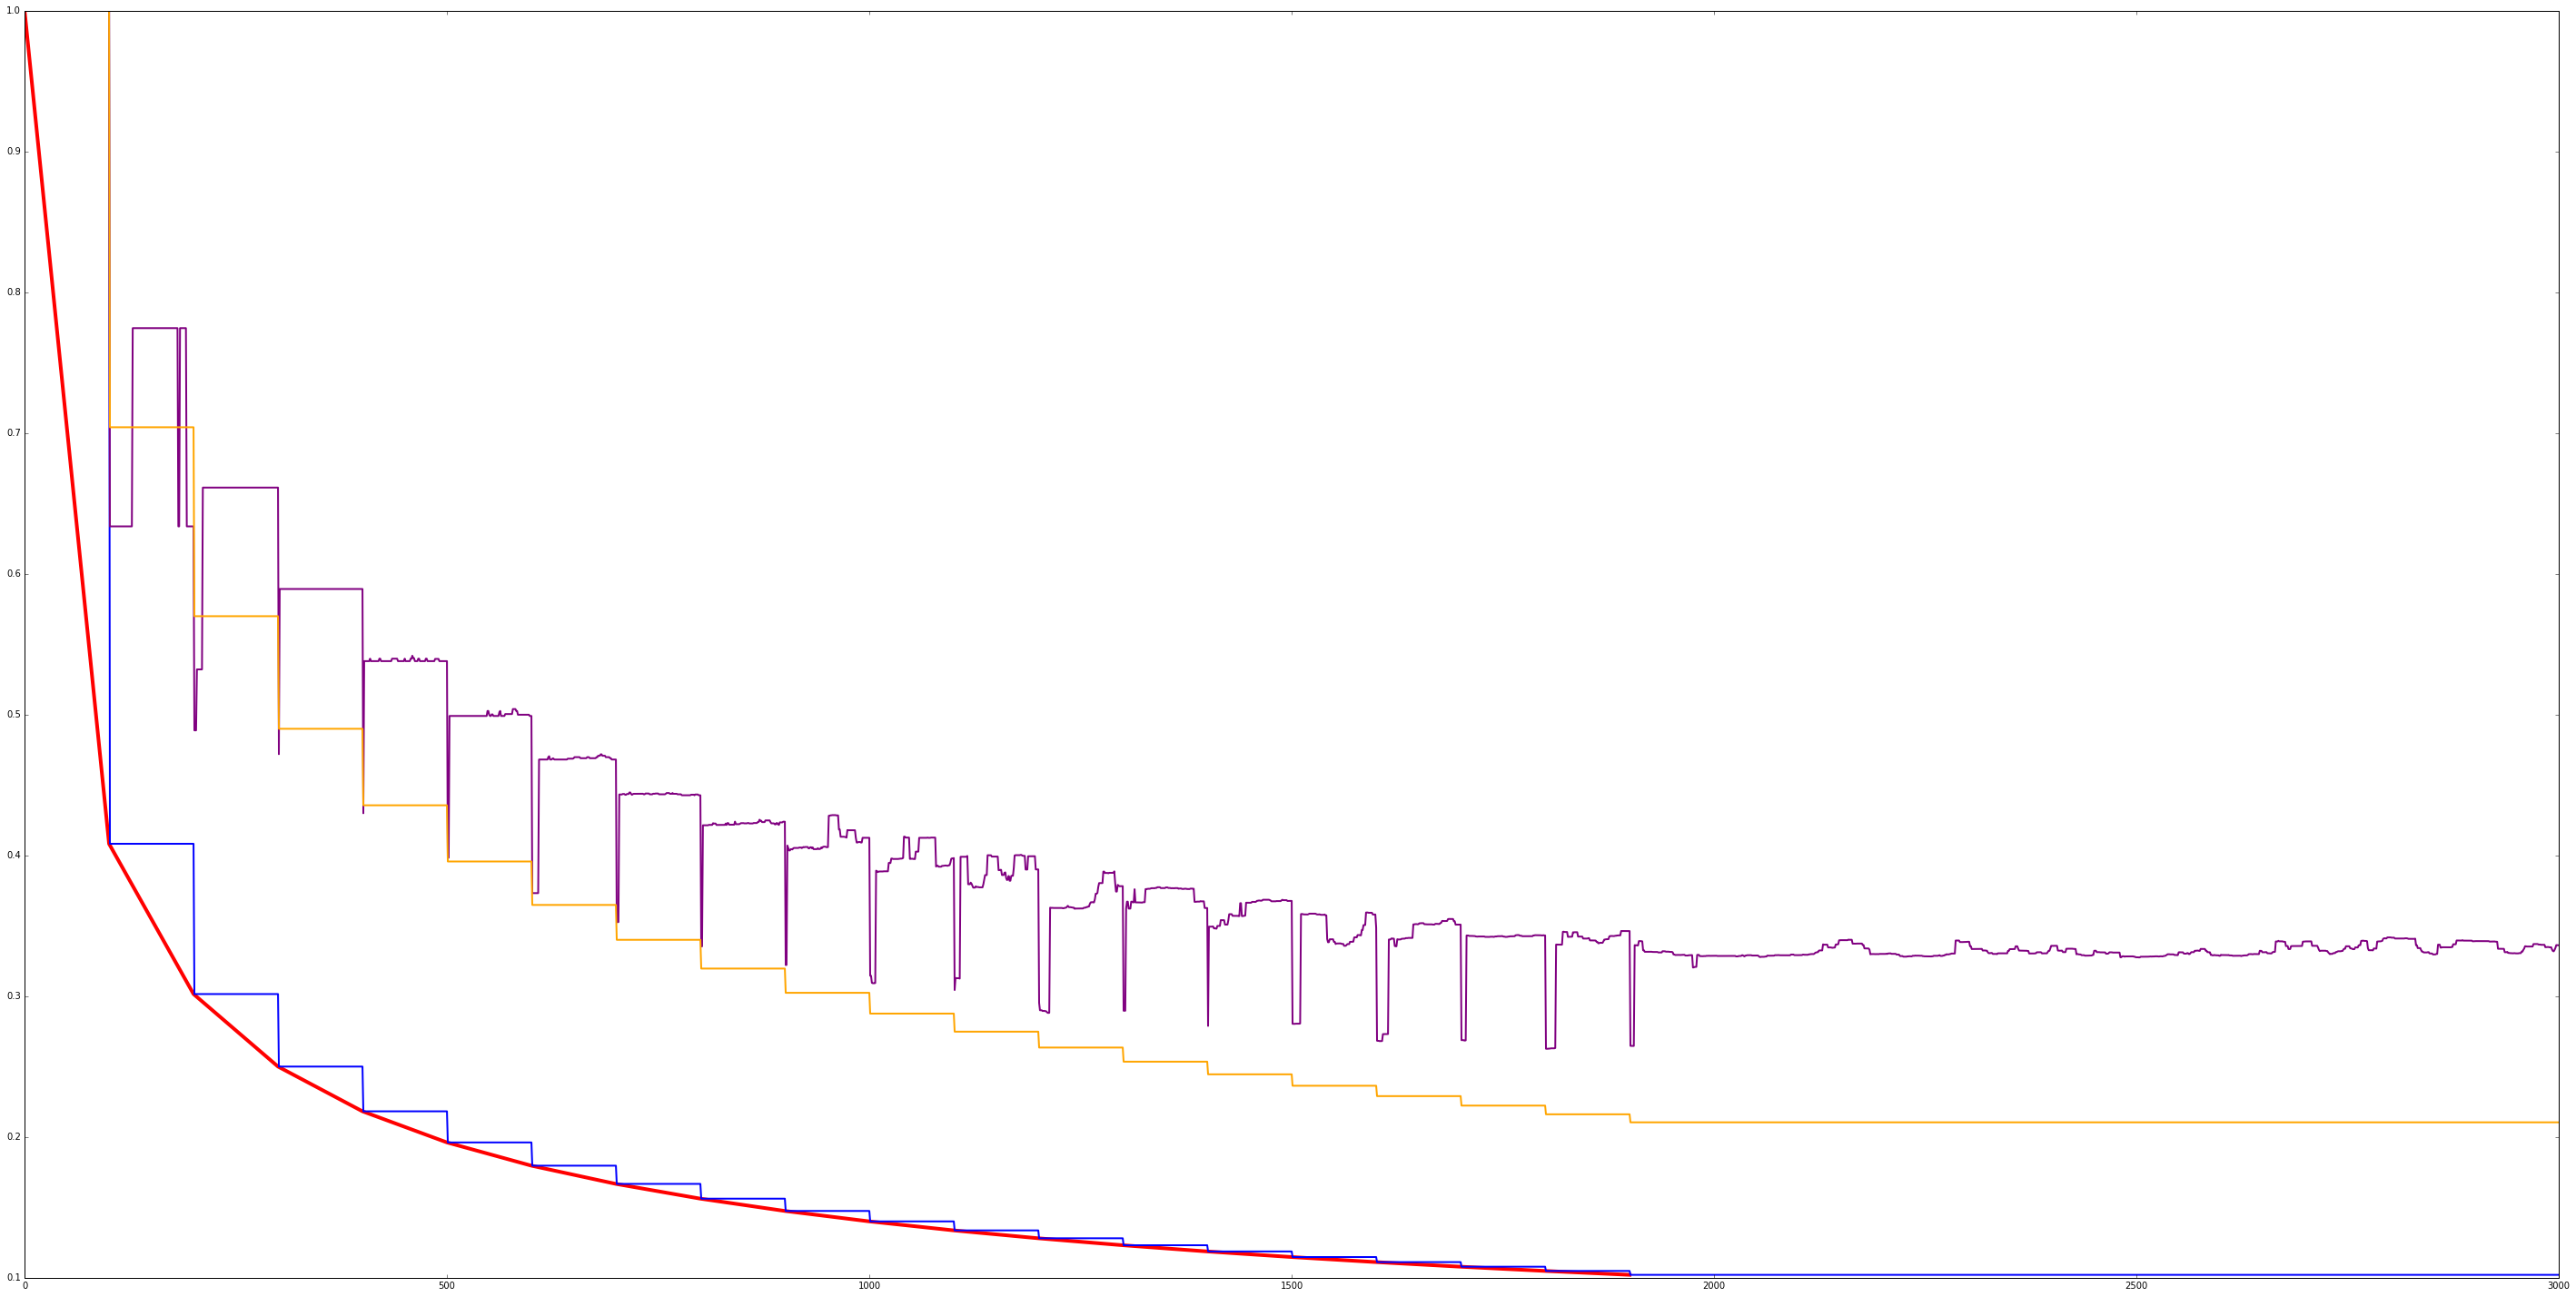

In [104]:
plt.figure(figsize=(50,25))
# Ground truth
plt.plot([i*timesteps for i in range(len(dataset))], dataset, color="r", linewidth=4)

plt.plot([i + 1 for i in range(len(fresh_exps))], fresh_exps, color="b", linewidth=2)

# plt.plot([i for i in range(len(uniform_estimates))], uniform_estimates, color="g", linewidth=2)

plt.plot([i + 1 for i in range(len(p_exps))], p_exps, color="purple", linewidth=2)

plt.plot([i + 1 for i in range(len(uniform_exps))], uniform_exps, color="orange", linewidth=2)

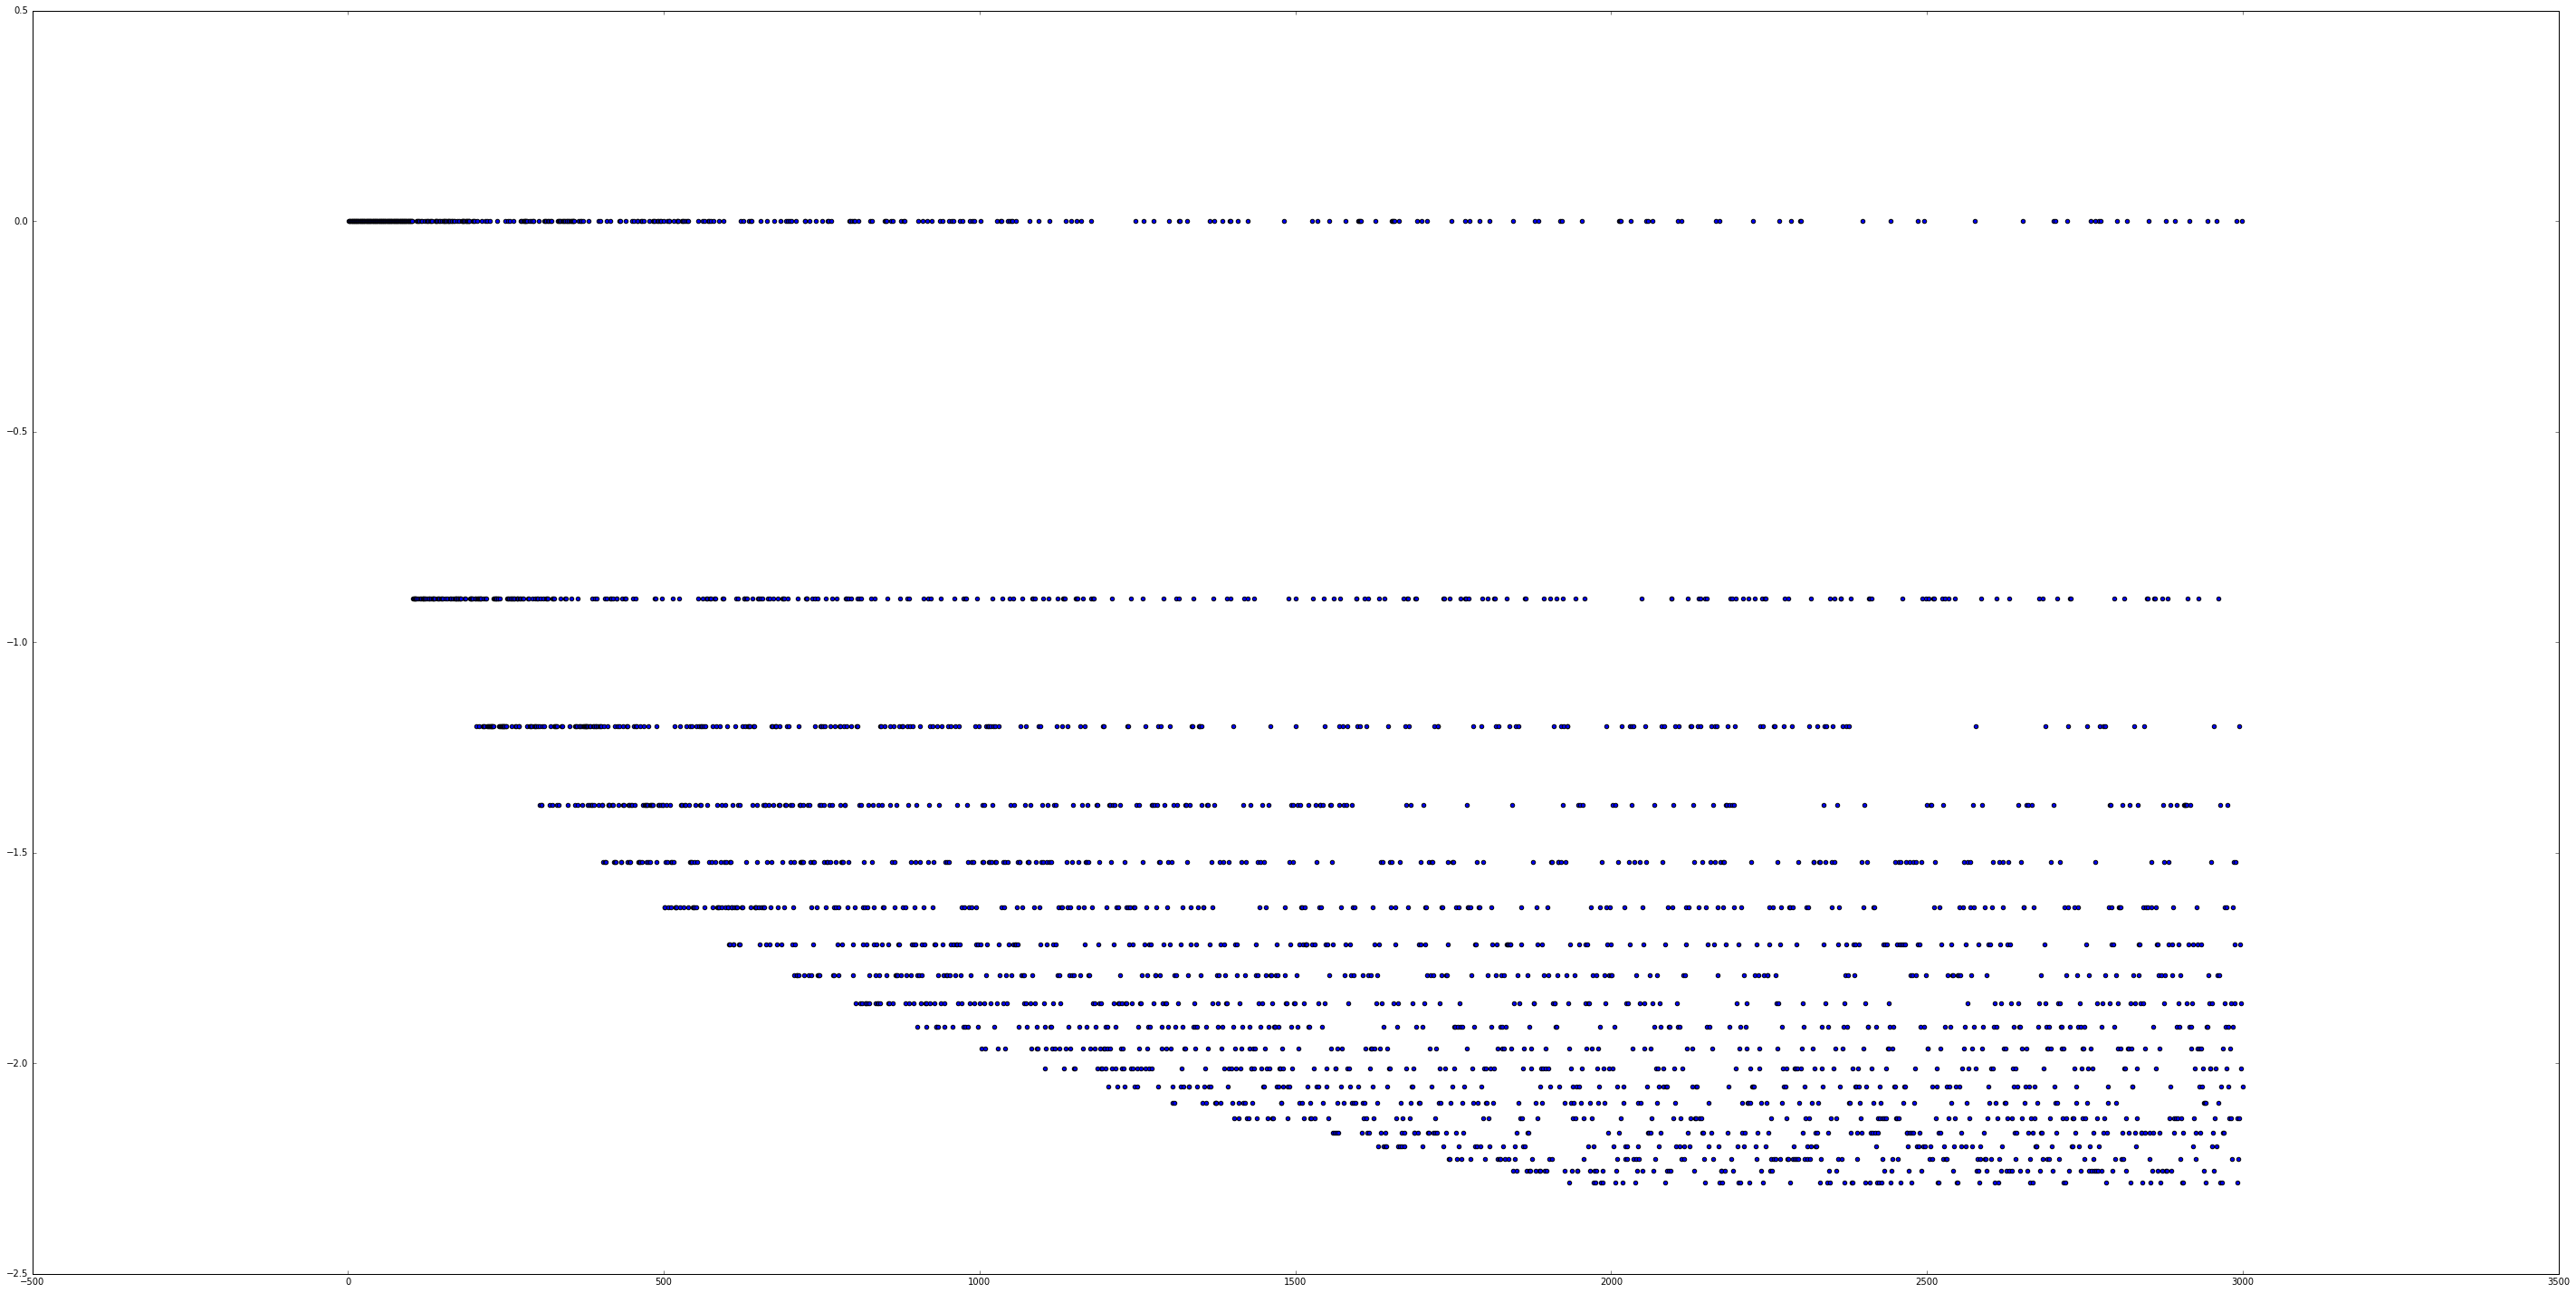

In [105]:
plt.figure(figsize=(50,25))

uniform_scatter_y = []
uniform_scatter_x = []

for i, ys in enumerate(uniform_replay.exps_at_t):
    for y in ys:
        uniform_scatter_x.append(i+1)
        uniform_scatter_y.append(np.log(y))

plt.scatter(uniform_scatter_x, uniform_scatter_y)
# plt.plot([i + 1 for i in range(len(p_exps))], p_exps, color="purple", linewidth=2)

# plt.plot([i + 1 for i in range(len(uniform_exps))], uniform_exps, color="orange", linewidth=2)

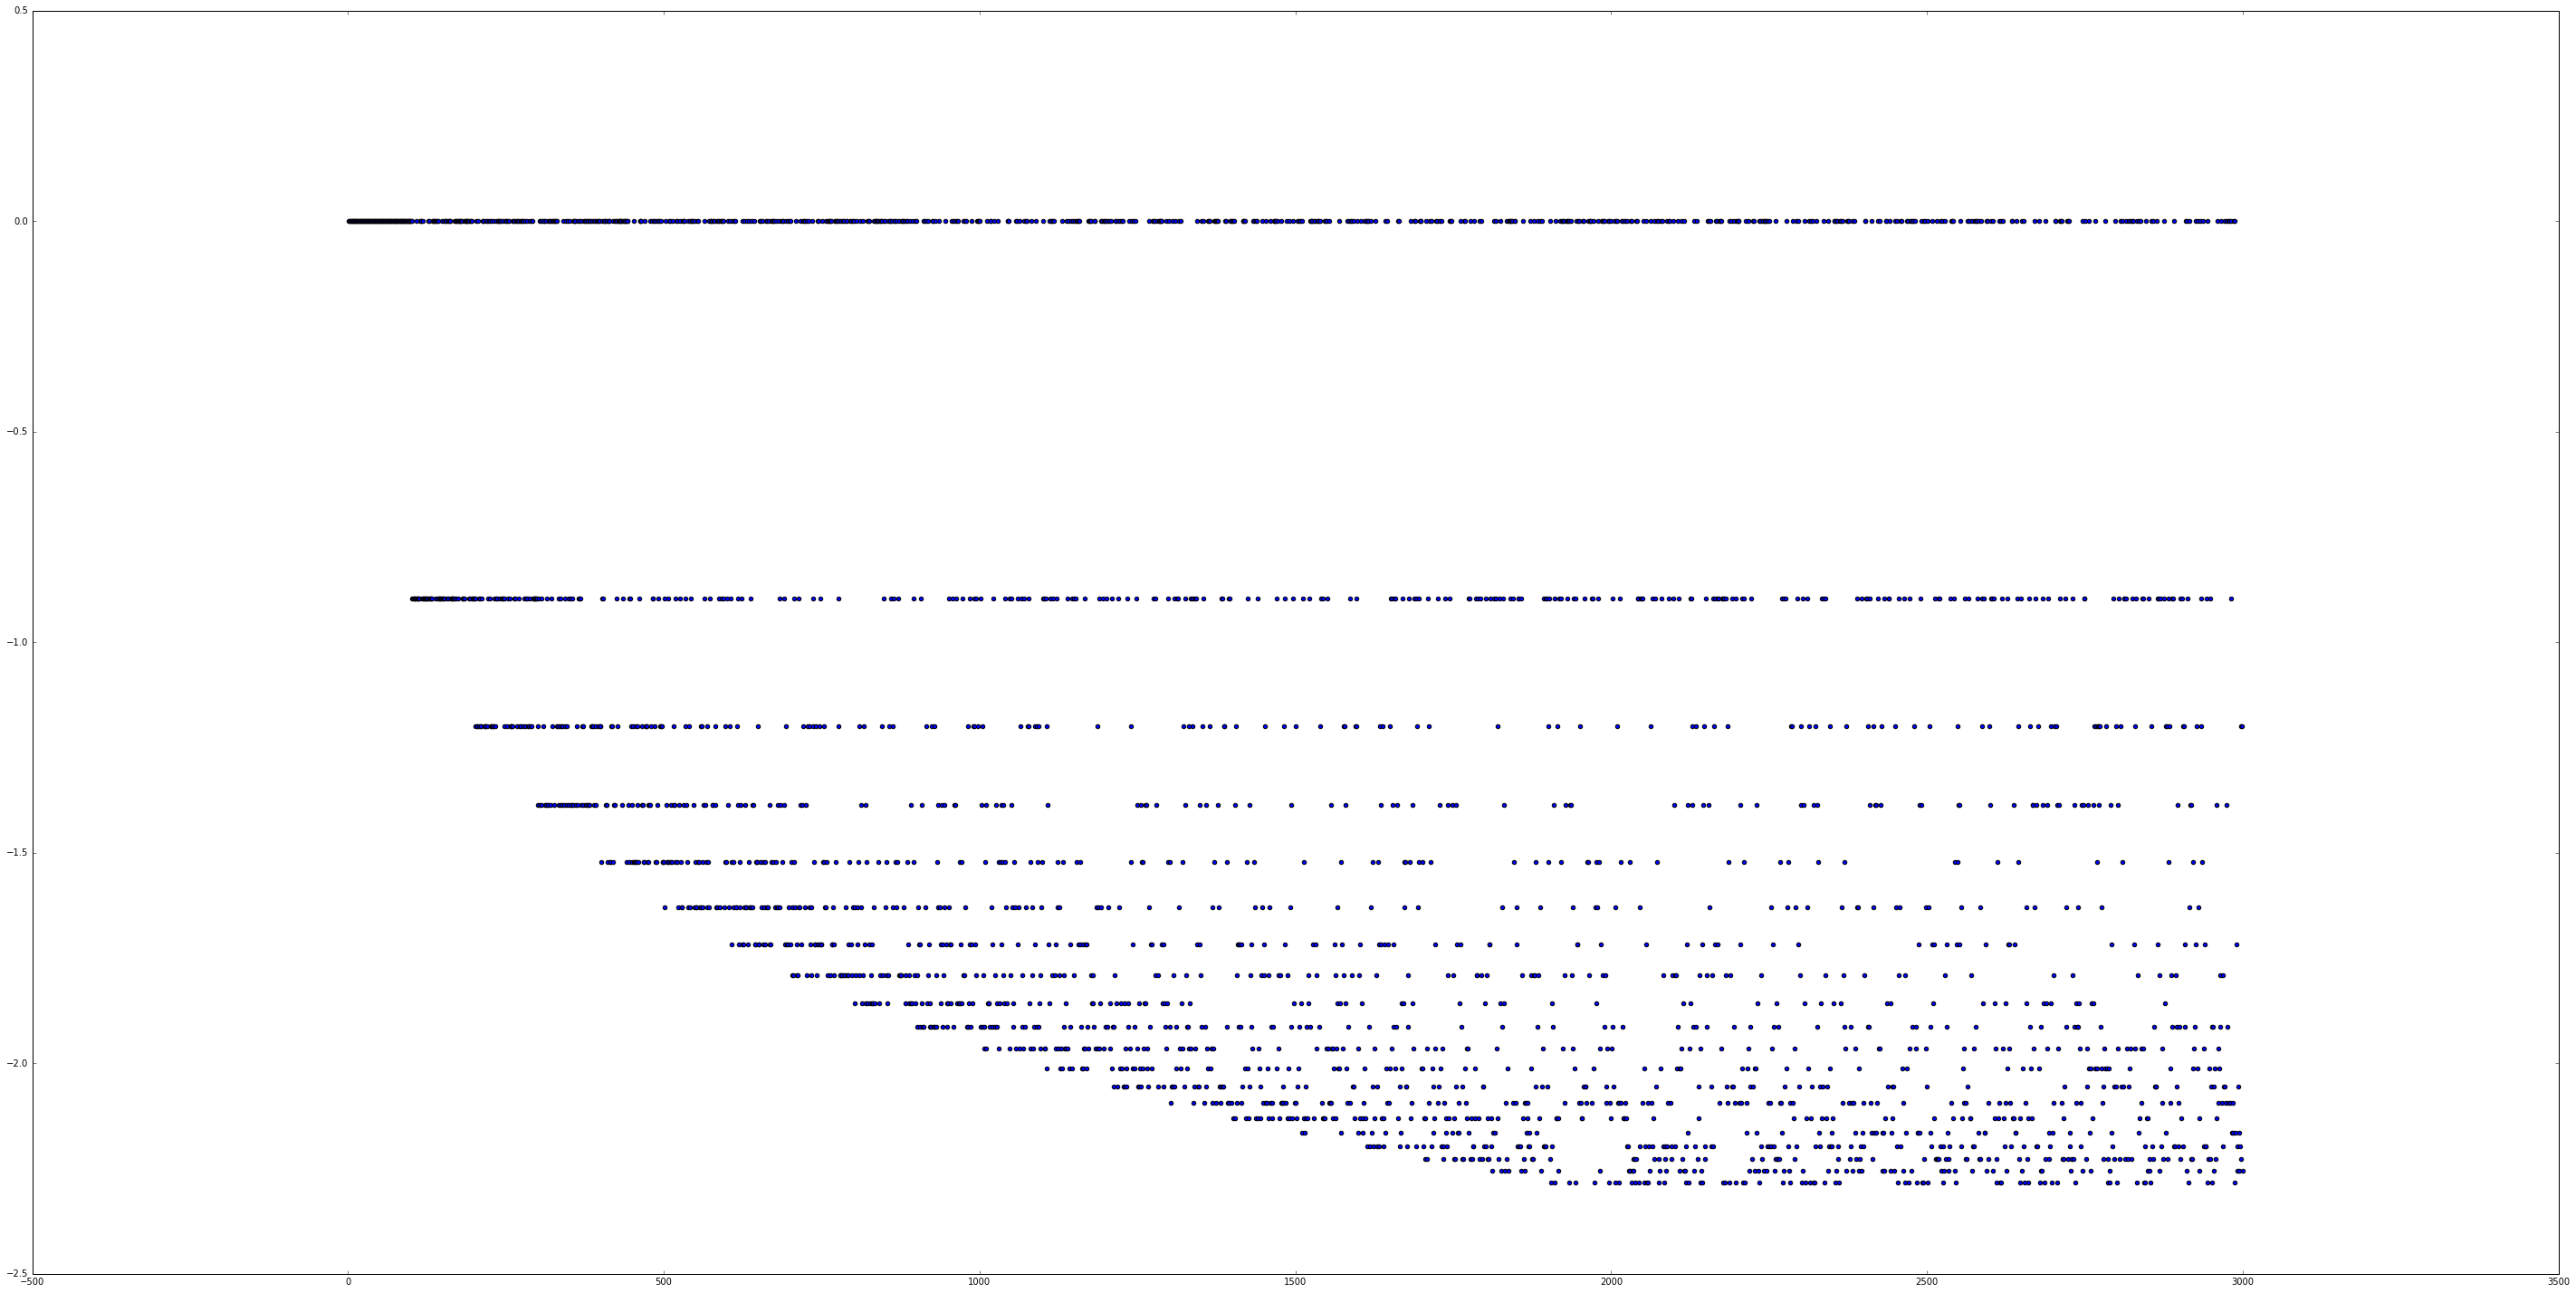

In [106]:
plt.figure(figsize=(50,25))

uniform_scatter_y = []
uniform_scatter_x = []

for i, ys in enumerate(p_replay.exps_at_t):
    for y in ys:
        uniform_scatter_x.append(i+1)
        uniform_scatter_y.append(np.log(y))

plt.scatter(uniform_scatter_x, uniform_scatter_y)
# plt.plot([i + 1 for i in range(len(p_exps))], p_exps, color="purple", linewidth=2)

# plt.plot([i + 1 for i in range(len(uniform_exps))], uniform_exps, color="orange", linewidth=2)

In [107]:
from mpl_toolkits.mplot3d import Axes3D

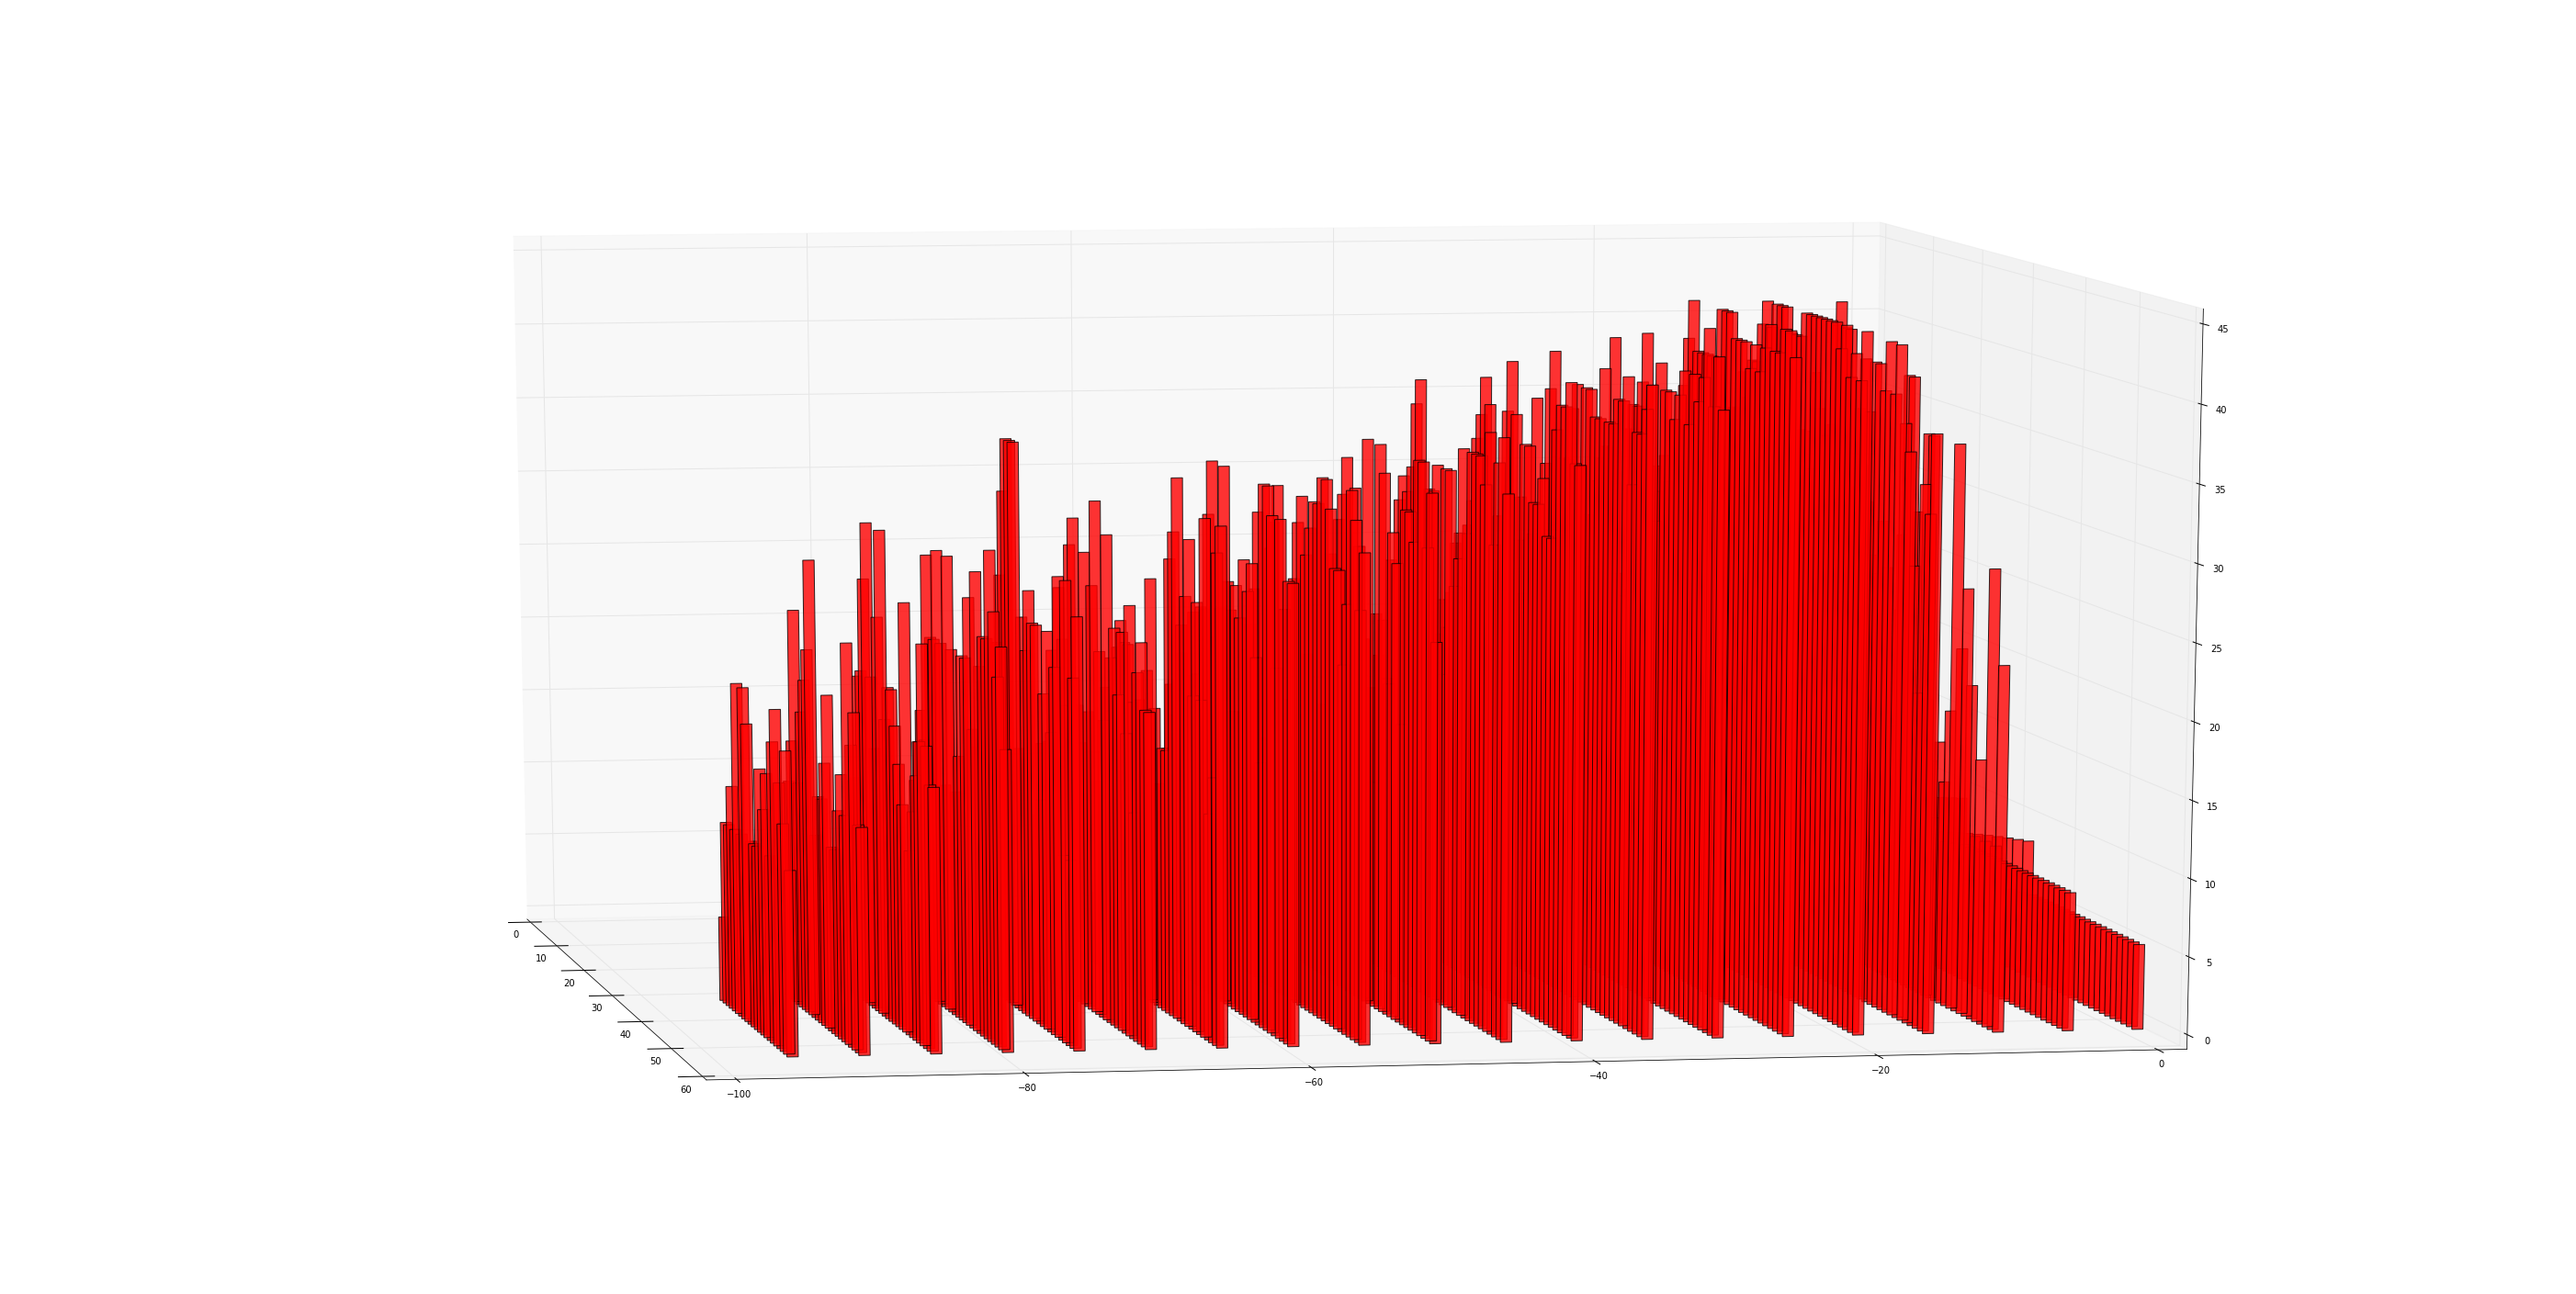

In [149]:
fig = plt.figure(figsize=(50,25))
ax = fig.add_subplot(111, projection="3d")

distribs = [p for i, p in enumerate(p_replay.distrib_at_t) if i % 50==0]
# print(distribs)
# distribs = p_replay.distrib_at_t[0: 2000]

x_points = []
y_points = []
z_points = []

for x in range(len(distribs)):
#     missing = 20 - len(distribs[x])
    zs = distribs[x]
#     print(zs)
#     zs += [0 for _ in range(missing)]
    cc = []
    vv = []
    ic = 0
    for v, c in zs:
        cc.append(-1/(c**2))
#         cc.append(c)
        ic+=1
        vv.append(1/v)
    ax.bar(cc,vv,zs=x, zdir="x", alpha=0.8, color="r")
#     break
    for z, y in zs:
#         print(y, z)
        x_points.append(x)
        y = -1/(y**2)
        y_points.append(y)
#         z = np.log(z)
        z_points.append(z)

#     for z, y in reversed(zs):
# #         print(y, z)
#         x_points.append(x)
#         y = -1/(y**2)
#         y_points.append(y)
# #         z = np.log(z)
#         z_points.append(z)

# x_points = [x * 100 for x in x_points]
# y_points = [y * 100 for y in y_points]
# z_points = [z * 100 for z in z_points]

ax.view_init(10, -10)

# print(distribs[-1])

# X, Y = np.meshgrid(x_points, y_points)
# ax.scatter(x_points, y_points, z_points, color="b")
# ax.plot_wireframe(x_points, y_points, z_points)
# ax.contour(x_points, y_points, z_points)